# Simple quadratic convex problems

@Author: Ettore Biondi - ettore88@stanford.edu

## Instantiation of vectors and operator
For testing the library we will be using a discretized version of the following operator:
\begin{align}
y = \frac{d^2f(x)}{dx^2},
\end{align}
in which we simply compute the second-order derivative of a function $f(x)$. 

#### Importing necessary libraries

In [1]:
# Importing necessary modules
import numpy as np
import occamypy

# Plotting library
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': False
}
matplotlib.rcParams.update(params)

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


In [2]:
N = 200  # Number of points of the function f(x)
dx = 1/N  # Sampling of the function
D2 = np.zeros((N, N), dtype=np.float64) #Matrix containing the discretization of the derivative operator
#The stencil used is simply: (f(ix-1)-2f(ix)+f(ix+1))/(dx*dx)
np.fill_diagonal(D2, -2 / (dx * dx))
np.fill_diagonal(D2[1:], 1 / (dx * dx))
np.fill_diagonal(D2[:,1:], 1 / (dx * dx))
f = occamypy.VectorNumpy(np.zeros((N, 1), dtype=np.float64)) #Initializing numpy-based vector for f(x)
y = occamypy.VectorNumpy(np.zeros((N, 1), dtype=np.float64)) #Initializing numpy-based vector for y
D2Op = occamypy.Matrix(D2, f, y)

Before we set any inversion problem, we study some of the properties of the constructed operator Deriv2Op.

In [3]:
#Verifying operator adjointness through dot-product test
D2Op.dotTest(verbose=True)
#Computing maximum and minimum eigenvalues of the operator using the power iteration method and 
#compare them against the ones computed using numpy
egsOp = D2Op.powerMethod(verbose=False, eval_min=True, tol=1e-300)
egsNp, _ = np.linalg.eig(D2)
egsNp = egsNp[egsNp.argsort()[::-1]] #Sorting the eigenvalues
print("\nMaximum eigenvalue: %s (Power method), %s (NUMPY)" % (egsOp[0], egsNp[-1]))
print(  "Minimum eigenvalue: %s (Power method), %s (NUMPY)" % (egsOp[1], egsNp[0]))

Dot-product tests of forward and adjoint operators
--------------------------------------------------
Applying forward operator add=False
 Runs in: 0.05012845993041992 seconds
Applying adjoint operator add=False
 Runs in: 0.00012969970703125 seconds
Dot products add=False: domain=9.769895e+04 range=9.769895e+04 
Absolute error: 2.910383e-11
Relative error: 2.978930e-16 

Applying forward operator add=True
 Runs in: 8.344650268554688e-05 seconds
Applying adjoint operator add=True
 Runs in: 9.322166442871094e-05 seconds
Dot products add=True: domain=1.953979e+05 range=1.953979e+05 
Absolute error: 5.820766e-11
Relative error: 2.978930e-16 

-------------------------------------------------

Maximum eigenvalue: -159990.22855483848 (Power method), -159990.2285552522 (NUMPY)
Minimum eigenvalue: -9.771445145423058 (Power method), -9.771444747760874 (NUMPY)


We can see that the matrix is negative definite. The small mismatch in the estimated eigenvalues is due to the dependence of the power method on the initial random eigenvector.

## Inversion tests
We will now focus our attention on inverting a function knowning its second-order derivative. In this case we will assume that $y$ is constant and equal to $1$. Therefore, we expect to obtain a parabola with positive curvature. Given the chosen boundary conditions we know that the matrix is invertible since all eigenvalues have the same sign and are different then zero.
We will solve the following objective functions using linear conjugate-gradient methods:
\begin{equation*}
\phi_1(\mathbf{f}) = \frac{1}{2}\|D_2\mathbf{f}-\mathbf{y}\|_2^2
\end{equation*}
and
\begin{equation*}
\phi_2(\mathbf{f}) = \frac{1}{2}\mathbf{f}^T D_2 \mathbf{f} - \mathbf{f}^{T} \mathbf{y},
\end{equation*}
where $D_2$ represents the discretized second-order derivative operator, while $\mathbf{f}$ and $\mathbf{y}$ are the discretized representations of $f$ and $y$, respectively.

In [4]:
y.set(1.) # y = 1
#Note that f = 0
Phi1 = occamypy.LeastSquares(f.clone(), y, D2Op)
Phi2 = occamypy.LeastSquaresSymmetric(f.clone(), y, D2Op)

### Instantiation of solver objects
First, we create two different solver object for solving the two inversion problem stated above.

In [5]:
#Create stopping criteria and related object
niter = 2000
Stop  = occamypy.BasicStopper(niter=niter)
#Create LCG solver
LCGsolver = occamypy.CG(Stop)
LCGsolver.setDefaults(save_obj=True) #Saving objective function within the solver
#Create LCG solver for symmetric systems
SLCG = occamypy.CGsym(Stop)
SLCG.setDefaults(save_obj=True, save_model=True)

Secondly, we run the solvers to minimize the objective functions previously defined.

In [6]:
LCGsolver.run(Phi1, verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT SOLVER
	Restart folder: /tmp/restart_2020-12-07T23-42-02.028903/
	Modeling Operator:		MatrixOp
##########################################################################################

iter = 0000, obj = 1.00000e+02, resnorm = 1.41e+01, gradnorm = 5.66e+04, feval = 2
iter = 0001, obj = 9.98000e+01, resnorm = 1.41e+01, gradnorm = 4.66e+04, feval = 4
iter = 0002, obj = 9.96483e+01, resnorm = 1.41e+01, gradnorm = 4.20e+04, feval = 6
iter = 0003, obj = 9.95208e+01, resnorm = 1.41e+01, gradnorm = 3.90e+04, feval = 8
iter = 0004, obj = 9.94086e+01, resnorm = 1.41e+01, gradnorm = 3.69e+04, feval = 10
iter = 0005, obj = 9.93072e+01, resnorm = 1.41e+01, gradnorm = 3.52e+04, feval = 12
iter = 0006, obj = 9.92139e+01, resnorm = 1.41e+01, gradnorm = 3.39e+04, feval = 14
iter = 0007, obj = 9.91271e+01, resnorm = 1.41e+01, gradnorm = 3.28e+04, feval = 16
iter = 0008, obj = 9.904

iter = 0201, obj = 9.00808e+01, resnorm = 1.34e+01, gradnorm = 5.59e+04, feval = 404
iter = 0202, obj = 8.98263e+01, resnorm = 1.34e+01, gradnorm = 5.54e+04, feval = 406
iter = 0203, obj = 8.95554e+01, resnorm = 1.34e+01, gradnorm = 4.19e+04, feval = 408
iter = 0204, obj = 8.94344e+01, resnorm = 1.34e+01, gradnorm = 3.46e+04, feval = 410
iter = 0205, obj = 8.93485e+01, resnorm = 1.34e+01, gradnorm = 3.08e+04, feval = 412
iter = 0206, obj = 8.92898e+01, resnorm = 1.34e+01, gradnorm = 2.17e+04, feval = 414
iter = 0207, obj = 8.92592e+01, resnorm = 1.34e+01, gradnorm = 1.63e+04, feval = 416
iter = 0208, obj = 8.92438e+01, resnorm = 1.34e+01, gradnorm = 1.34e+04, feval = 418
iter = 0209, obj = 8.92335e+01, resnorm = 1.34e+01, gradnorm = 8.87e+03, feval = 420
iter = 0210, obj = 8.92284e+01, resnorm = 1.34e+01, gradnorm = 5.93e+03, feval = 422
iter = 0211, obj = 8.92256e+01, resnorm = 1.34e+01, gradnorm = 4.44e+03, feval = 424
iter = 0212, obj = 8.92242e+01, resnorm = 1.34e+01, gradnorm = 3.

iter = 0405, obj = 1.17739e-03, resnorm = 4.85e-02, gradnorm = 9.75e+02, feval = 812
iter = 0406, obj = 1.12091e-03, resnorm = 4.73e-02, gradnorm = 1.07e+03, feval = 814
iter = 0407, obj = 1.00921e-03, resnorm = 4.49e-02, gradnorm = 8.25e+02, feval = 816
iter = 0408, obj = 9.65013e-04, resnorm = 4.39e-02, gradnorm = 9.92e+02, feval = 818
iter = 0409, obj = 7.20566e-04, resnorm = 3.80e-02, gradnorm = 1.39e+03, feval = 820
iter = 0410, obj = 6.24131e-04, resnorm = 3.53e-02, gradnorm = 1.25e+03, feval = 822
iter = 0411, obj = 3.90908e-04, resnorm = 2.80e-02, gradnorm = 1.53e+03, feval = 824
iter = 0412, obj = 2.91293e-04, resnorm = 2.41e-02, gradnorm = 8.53e+02, feval = 826
iter = 0413, obj = 2.22030e-04, resnorm = 2.11e-02, gradnorm = 1.00e+03, feval = 828
iter = 0414, obj = 1.78123e-04, resnorm = 1.89e-02, gradnorm = 3.72e+02, feval = 830
iter = 0415, obj = 1.65312e-04, resnorm = 1.82e-02, gradnorm = 4.81e+02, feval = 832
iter = 0416, obj = 1.52973e-04, resnorm = 1.75e-02, gradnorm = 2.

iter = 0613, obj = 3.56694e-15, resnorm = 8.45e-08, gradnorm = 1.19e-03, feval = 1228
iter = 0614, obj = 3.47913e-15, resnorm = 8.34e-08, gradnorm = 1.11e-03, feval = 1230
iter = 0615, obj = 3.37873e-15, resnorm = 8.22e-08, gradnorm = 8.75e-04, feval = 1232
iter = 0616, obj = 3.34732e-15, resnorm = 8.18e-08, gradnorm = 3.74e-04, feval = 1234
iter = 0617, obj = 3.33796e-15, resnorm = 8.17e-08, gradnorm = 3.71e-04, feval = 1236
iter = 0618, obj = 3.32235e-15, resnorm = 8.15e-08, gradnorm = 4.96e-04, feval = 1238
iter = 0619, obj = 3.30050e-15, resnorm = 8.12e-08, gradnorm = 5.11e-04, feval = 1240
iter = 0620, obj = 3.27761e-15, resnorm = 8.10e-08, gradnorm = 7.47e-04, feval = 1242
iter = 0621, obj = 3.12276e-15, resnorm = 7.90e-08, gradnorm = 1.68e-03, feval = 1244
iter = 0622, obj = 2.85907e-15, resnorm = 7.56e-08, gradnorm = 1.35e-03, feval = 1246
iter = 0623, obj = 2.73793e-15, resnorm = 7.40e-08, gradnorm = 1.29e-03, feval = 1248
iter = 0624, obj = 2.55298e-15, resnorm = 7.15e-08, gr

iter = 0807, obj = 8.29810e-20, resnorm = 4.07e-10, gradnorm = 3.96e-07, feval = 1616
iter = 0808, obj = 8.29593e-20, resnorm = 4.07e-10, gradnorm = 6.02e-07, feval = 1618
iter = 0809, obj = 8.28341e-20, resnorm = 4.07e-10, gradnorm = 1.38e-06, feval = 1620
iter = 0810, obj = 8.26803e-20, resnorm = 4.07e-10, gradnorm = 1.73e-06, feval = 1622
iter = 0811, obj = 8.24765e-20, resnorm = 4.06e-10, gradnorm = 1.58e-06, feval = 1624
iter = 0812, obj = 8.21369e-20, resnorm = 4.05e-10, gradnorm = 1.65e-06, feval = 1626
iter = 0813, obj = 8.18937e-20, resnorm = 4.05e-10, gradnorm = 8.75e-07, feval = 1628
iter = 0814, obj = 8.16157e-20, resnorm = 4.04e-10, gradnorm = 1.87e-06, feval = 1630
iter = 0815, obj = 8.12325e-20, resnorm = 4.03e-10, gradnorm = 2.08e-06, feval = 1632
iter = 0816, obj = 8.10374e-20, resnorm = 4.03e-10, gradnorm = 1.50e-06, feval = 1634
iter = 0817, obj = 8.08224e-20, resnorm = 4.02e-10, gradnorm = 1.37e-06, feval = 1636
iter = 0818, obj = 8.07042e-20, resnorm = 4.02e-10, gr

iter = 1014, obj = 1.02811e-22, resnorm = 1.43e-11, gradnorm = 3.19e-08, feval = 2030
iter = 1015, obj = 1.02703e-22, resnorm = 1.43e-11, gradnorm = 4.92e-08, feval = 2032
iter = 1016, obj = 1.02325e-22, resnorm = 1.43e-11, gradnorm = 4.58e-08, feval = 2034
iter = 1017, obj = 1.02232e-22, resnorm = 1.43e-11, gradnorm = 3.58e-08, feval = 2036
iter = 1018, obj = 1.02111e-22, resnorm = 1.43e-11, gradnorm = 3.33e-08, feval = 2038
iter = 1019, obj = 1.02060e-22, resnorm = 1.43e-11, gradnorm = 1.77e-08, feval = 2040
iter = 1020, obj = 1.02041e-22, resnorm = 1.43e-11, gradnorm = 1.27e-08, feval = 2042
iter = 1021, obj = 1.02029e-22, resnorm = 1.43e-11, gradnorm = 1.46e-08, feval = 2044
iter = 1022, obj = 1.02005e-22, resnorm = 1.43e-11, gradnorm = 1.60e-08, feval = 2046
iter = 1023, obj = 1.01989e-22, resnorm = 1.43e-11, gradnorm = 1.42e-08, feval = 2048
iter = 1024, obj = 1.01977e-22, resnorm = 1.43e-11, gradnorm = 8.78e-09, feval = 2050
iter = 1025, obj = 1.01955e-22, resnorm = 1.43e-11, gr

In [7]:
SLCG.run(Phi2, verbose=True)

##########################################################################################

iter = 0000, obj = 0.00000e+00, resnorm = 1.41e+01, feval = 1
iter = 0001, obj = 2.50000e-01, resnorm = 1.41e+02, feval = 3
iter = 0002, obj = 4.95025e-01, resnorm = 1.39e+02, feval = 5
iter = 0003, obj = 7.35125e-01, resnorm = 1.38e+02, feval = 7
iter = 0004, obj = 9.70350e-01, resnorm = 1.36e+02, feval = 9
iter = 0005, obj = 1.20075e+00, resnorm = 1.35e+02, feval = 11
iter = 0006, obj = 1.42638e+00, resnorm = 1.34e+02, feval = 13
iter = 0007, obj = 1.64727e+00, resnorm = 1.32e+02, feval = 15
iter = 0008, obj = 1.86350e+00, resnorm = 1.31e+02, feval = 17
iter = 0009, obj = 2.07510e+00, resnorm = 1.29e+02, feval = 19
iter = 0010, obj = 2.28213e+00, resnorm = 1.28e+02, feval = 21
iter = 0011, obj = 2.48463e+00, resnorm = 1.27e+02, feval = 23
iter = 0012, obj = 2.68265e+00, resnorm = 1.25e+02, feval = 25
iter = 0013, obj = 2.87625e+00, resnorm = 1.24e+02, feval = 27
iter = 0014, obj = 3.06548e+00,

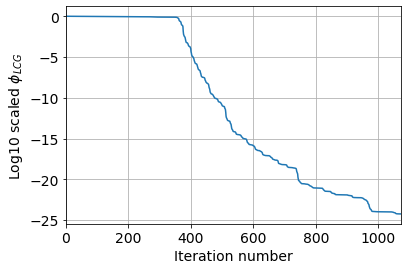

In [8]:
plt.plot(np.log10(LCGsolver.obj / LCGsolver.obj[0]))
# plt.title("LCG convergence")
plt.xlabel("Iteration number", fontsize=14)
plt.ylabel("Log10 scaled $\phi_{LCG}$", fontsize=14)
ax = plt.gca() 
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)

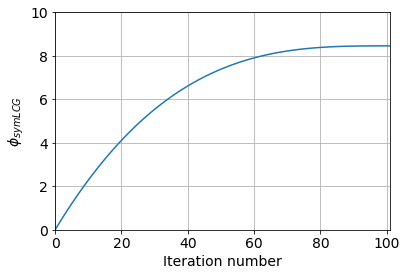

In [9]:
plt.plot(SLCG.obj)
# plt.title("Symmetric LCG convergence")
plt.xlabel("Iteration number", fontsize=14)
plt.ylabel("$\phi_{symLCG}$", fontsize=14)
ax = plt.gca() 
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([0,10])
ax.autoscale(enable=True, axis='x', tight=True)

Also, let's compare the two inverted functions with the analytical solution.
To find the solution for the continuous case we need three conditions:
\begin{equation}
\frac{d^2f(x)}{dx^2}=1,\\
f(x=0)=0,\\
f(x=x_f)=0.
\end{equation}
$x = 0$ and $x = x_f$ are not sampled and lay outside of the interval $\mathbf{x}$.

In [10]:
X = np.linspace(dx, N*dx, N)
alpha = 0.5
beta  = -(X[-1] + dx) * 0.5
gamma = 0.0
f_an  = alpha * X * X + beta * X + gamma

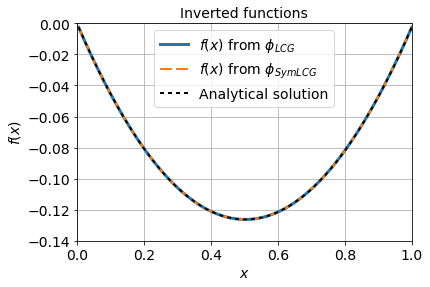

In [11]:
plt.plot(X, Phi1.model.plot(), linewidth=3, label="$f(x)$ from $\phi_{LCG}$")
plt.plot(X, Phi2.model.plot(), linewidth=2, dashes=[6, 2], label="$f(x)$ from $\phi_{SymLCG}$")
plt.plot(X, f_an, 'k', linewidth=2, dashes=[2, 2], label="Analytical solution")
ax = plt.gca() 
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend()
plt.grid()
plt.xlabel(r"$x$", fontsize=14)
plt.ylabel("$f(x)$", fontsize=14)
plt.ylim([-0.14, 0])
plt.xlim([0, 1.])
_ = plt.title("Inverted functions")

Now, let's try to solve both inversions using the inverse of $D_2$ as a preconditioner

In [12]:
PrecOp = occamypy.Matrix(np.linalg.inv(D2), f, y) # P = [D_2]^-1
Phi1Prec = occamypy.LeastSquares(f.clone(), y, D2Op, prec=PrecOp*PrecOp) #In this line we chain [D_2]^-1 twice
Phi2Prec = occamypy.LeastSquaresSymmetric(f.clone(), y, D2Op, prec=PrecOp)

In [13]:
LCGsolver.setDefaults() # Re-setting default solver values
SLCG.setDefaults() # Re-setting default solver values

In [14]:
LCGsolver.run(Phi1Prec, verbose=True)

##########################################################################################
				PRECONDITIONED LINEAR CONJUGATE GRADIENT SOLVER
	Restart folder: /tmp/restart_2020-12-07T23-42-02.028903/
	Modeling Operator:		MatrixOp
##########################################################################################

iter = 0000, obj = 1.00000e+02, resnorm = 1.41e+01, gradnorm = 5.66e+04, feval = 2
iter = 0001, obj = 2.85104e-22, resnorm = 2.39e-11, gradnorm = 3.15e-06, feval = 4
iter = 0002, obj = 8.97216e-46, resnorm = 4.24e-23, gradnorm = 9.85e-19, feval = 6
Objective function didn't reduce, will terminate solver:
	obj_new = 8.97216e-46	obj_cur = 8.97216e-46
##########################################################################################
				PRECONDITIONED LINEAR CONJUGATE GRADIENT SOLVER end
##########################################################################################



In [15]:
SLCG.run(Phi2Prec, verbose=True)

##########################################################################################

iter = 0000, obj = 0.00000e+00, resnorm = 1.41e+01, feval = 1
iter = 0001, obj = 8.45875e+00, resnorm = 2.08e-11, feval = 3
iter = 0002, obj = 8.45875e+00, resnorm = 2.61e-24, feval = 5
Objective function variation not monotonic, will terminate solver:obj_old=8.45875e+00 obj_cur=8.45875e+00 obj_new=8.45875e+00
##########################################################################################
PRECONDITIONED LINEAR CONJUGATE GRADIENT SOLVER FOR SYMMETRIC MATRIX end
##########################################################################################



As expected, we converge to the global minimum in effectively one iteration.